In [1]:
import os
import pandas as pd
import numpy as np
import gensim
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow import keras
from winsound import Beep
import matplotlib.pyplot as plt
from winsound import Beep

In [2]:
def read_data_from_dir(data_dir):
    x_data = []
    y_data = []
    for class_dir in os.listdir(data_dir):
        class_dir_pth = os.path.join(data_dir, class_dir)
        print(f"working on {class_dir} ...")
        n_files = len(os.listdir(class_dir_pth))
        for i, document in enumerate(os.listdir(class_dir_pth)):
            document_pth = os.path.join(class_dir_pth, document)
            with open(document_pth, encoding="UTF-8") as f:
                lines = f.readlines()
                x_data.append(lines[1])
                y_data.append(class_dir)
            print(f"{int(100 * i / n_files)} %", end='\r')
    print("done!")
#     df = pd.DataFrame(data=text, columns=["text"])
#     df["class"] = text_class
    return x_data, y_data

In [3]:
data_dir = "E:\Technical\Electro pi\SANAD_ Single-Label Arabic News Articles Dataset for Automatic Text Categorization\SANAD_SUBSET\khaleej"
train_data_dir = os.path.join(data_dir, "Train")
test_data_dir = os.path.join(data_dir, "Test")

x_train, y_train = read_data_from_dir(train_data_dir)
x_test, y_test = read_data_from_dir(test_data_dir)

working on Culture ...
working on Finance ...
working on Medical ...
working on Politics ...
working on Religion ...
working on Sports ...
working on Tech ...
done!
working on Culture ...
working on Finance ...
working on Medical ...
working on Politics ...
working on Religion ...
working on Sports ...
working on Tech ...
done!


In [4]:
x_train_cleaned = map(gensim.utils.simple_preprocess, x_train)
x_test_cleaned = map(gensim.utils.simple_preprocess, x_test)

x_train_cleaned = np.array(list(x_train_cleaned), dtype=object)
x_test_cleaned = np.array(list(x_test_cleaned), dtype=object)

In [5]:
Beep(2500, 1000)

In [9]:
wv_model = gensim.models.Word2Vec.load("word2vec-SANAD-khaleej-arabic-language.model")

In [10]:
def text2vect(text):
    n_words = len(text)
    text_vect = np.empty(n_words, 100)
    for i, word in enumerate(text):
        try:
            text_vect[i,:] = wv_model.wv[word]
        except KeyError:
            text_vect[i,:] = np.zeros(100)
    return text_vect

In [11]:
x_train_cleaned_vec = map(text2vect, x_train_cleaned)
x_test_cleaned_vec = map(text2vect, x_test_cleaned)

x_train_cleaned_vec = np.array(list(x_train_cleaned_vec))
x_test_cleaned_vec = np.array(list(x_test_cleaned_vec))

In [12]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [13]:
x_train_cleaned_vec.shape

(40950, 100)

In [14]:
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
#         self.restore_best_weights = restore_best_weights
#         self.mode = mode
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0.015

    def on_epoch_end(self, epoch, logs=None):
        current = logs["accuracy"] - logs["val_accuracy"]
        
        if current <= 0.015:
            self.wait = 0
            if np.less(current, self.best):
                self.best = current
            # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
#                 print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: custom early stopping" % (self.stopped_epoch + 1))
    

In [16]:
idx = np.arange(40950)
np.random.shuffle(idx)

x_train_cleaned_vec = x_train_cleaned_vec[idx]
y_train = y_train[idx]

In [17]:
x_train_cleaned_vec.shape

(40950, 100)

In [18]:
x_val, y_val = x_train_cleaned_vec[:5000], y_train[:5000]
x_train, y_train = x_train_cleaned_vec[5000:], y_train[5000:]

In [41]:
fully_connected_Model = keras.models.Sequential([
#     keras.layers.GRU(20, return_sequences=True, input_shape= [None, 1]),
#     keras.layers.GRU(20, input_shape= [None, 1]),
    keras.layers.Flatten(input_shape= (100, 1)),
    keras.layers.Dense(32, activation= "relu", ),
    keras.layers.Dense(32, activation= "relu"),
    keras.layers.Dense(32, activation= "relu"),
    keras.layers.Dense(32, activation= "relu"),
    keras.layers.Dense(7, activation= "softmax")
])

In [42]:
patience = 3
default_early_stopping_cb = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=patience, monitor="val_accuracy")
custom_early_stopping_cb = CustomEarlyStopping(patience=patience)
checkpoint_cb = keras.callbacks.ModelCheckpoint("sentiment_analysis_sanda_ModelCheckpoint.h5", monitor="val_accuracy", save_best_only=True, )

In [44]:
fully_connected_Model.compile(optimizer="adam", loss= keras.losses.sparse_categorical_crossentropy, metrics="accuracy")
history = fully_connected_Model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[checkpoint_cb, custom_early_stopping_cb], workers=8, use_multiprocessing=True)
Beep(2500, 1000)

Epoch 1/20
1124/1124 [==============================] - 3s 2ms/step - loss: 1.4520 - accuracy: 0.8296 - val_loss: 0.4113 - val_accuracy: 0.9112
Epoch 2/20
1124/1124 [==============================] - 2s 2ms/step - loss: 0.3394 - accuracy: 0.9181 - val_loss: 0.2845 - val_accuracy: 0.9338
Epoch 3/20
1124/1124 [==============================] - 2s 2ms/step - loss: 0.2598 - accuracy: 0.9329 - val_loss: 0.2336 - val_accuracy: 0.9432
Epoch 4/20
1124/1124 [==============================] - 2s 2ms/step - loss: 0.2181 - accuracy: 0.9418 - val_loss: 0.2502 - val_accuracy: 0.9398
Epoch 5/20
1124/1124 [==============================] - 2s 2ms/step - loss: 0.2009 - accuracy: 0.9466 - val_loss: 0.2023 - val_accuracy: 0.9490
Epoch 6/20
1124/1124 [==============================] - 2s 2ms/step - loss: 0.1772 - accuracy: 0.9507 - val_loss: 0.2097 - val_accuracy: 0.9520
Epoch 7/20
1124/1124 [==============================] - 2s 1ms/step - loss: 0.1695 - accuracy: 0.9543 - val_loss: 0.2135 - val_accuracy:

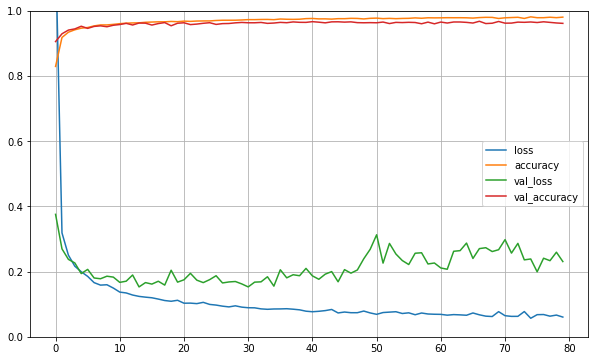

In [35]:
model_history = pd.DataFrame(history.history)
model_history.plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show();

In [45]:
fully_connected_Model.evaluate(x_val, y_val)

157/157 [==============================] - 0s 1ms/step - loss: 0.2008 - accuracy: 0.9592


[0.2007630467414856, 0.9592000246047974]

In [46]:
fully_connected_Model.evaluate(x_train, y_train)

1124/1124 [==============================] - 1s 1ms/step - loss: 0.0945 - accuracy: 0.9700


[0.09449124336242676, 0.9700417518615723]

In [47]:
fully_connected_Model.save("sentiment_analysis_sanad_fully_connected_Model.h5")

In [50]:
fully_connected_Model.evaluate(x_test_cleaned_vec, y_test)

143/143 [==============================] - 1s 2ms/step - loss: 0.1591 - accuracy: 0.9547


[0.15908674895763397, 0.9547252655029297]